In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

FileNotFoundError: [Errno 2] No such file or directory: 'banki_responses.json.bz2'

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [5]:
# проверим сколько всего отзывов

In [6]:
len(responses)

153499

In [7]:
# посмотрим сколько всего городов и отзывов в городах

In [8]:
cities = {}
for i in range(len(responses)):
    if responses[i]['city'] in cities:
        cities[responses[i]['city']]+=1
    else:
        cities.setdefault(responses[i]['city'], 1)        

In [9]:
# Посмотрим города с самым большим количеством отзывов

In [10]:
cities_sorted = sorted(cities.items(), key=lambda cities: cities[1], reverse=True)

In [11]:
len(cities_sorted)

5824

In [12]:
cities_sorted[:10] 

[('г. Москва', 55354),
 (None, 15174),
 ('г. Санкт-Петербург', 14342),
 ('г. Екатеринбург', 2337),
 ('г. Новосибирск', 2300),
 ('г. Нижний Новгород', 1976),
 ('г. Ростов-на-Дону', 1891),
 ('г. Самара', 1731),
 ('г. Челябинск', 1507),
 ('г. Казань', 1440)]

In [13]:
banks = {}
for i in range(len(responses)):
    if responses[i]['bank_name'] in banks:
        banks[responses[i]['bank_name']]+=1
    else:
        banks.setdefault(responses[i]['bank_name'], 1) 

In [14]:
banks_sorted = sorted(banks.items(), key=lambda banks: banks[1], reverse=True)

In [15]:
len(banks_sorted)

670

In [16]:
banks_sorted[:10]

[('Сбербанк России', 26327),
 ('Альфа-Банк', 10224),
 ('ВТБ 24', 8185),
 ('Русский Стандарт', 7943),
 ('Хоум Кредит Банк', 7549),
 ('Тинькофф Банк', 5387),
 ('Национальный Банк «Траст»', 4607),
 ('Ренессанс Кредит', 3849),
 ('Связной Банк', 3775),
 ('ОТП Банк', 3237)]

In [17]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [18]:
texts = []
for i in range(len(responses)):
    texts.append(responses[i]['text'])

In [19]:
len_texts = []
len_chars = []
for i in texts:
    len_texts.append(len(words_only(i, regex=regex).split(' ')))
    len_chars.append(len(i))

In [20]:
# построим гистограмму по количеству слов в текстах

/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


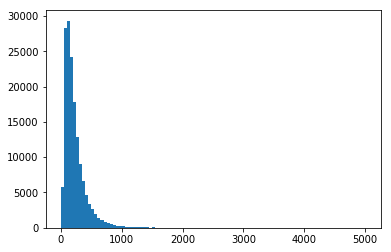

In [21]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(len_texts, bins  = 100)
fig.show()

In [22]:
# построим гистограмму по количеству символов в текстах

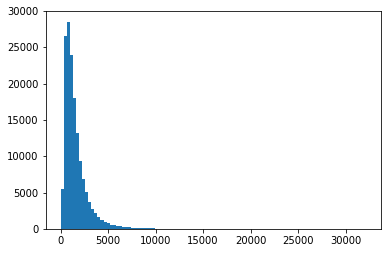

In [23]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(len_chars, bins  = 100)
fig.show()

In [24]:
# Посчитаем наиболее часто встречающиеся слова

In [25]:
texts = pd.DataFrame(texts)

In [26]:
texts.head()

,0
0,Добрый день! Я не являюсь клиентом банка и пор...
1,Доброго дня! Являюсь держателем зарплатной кар...
2,Здравствуйте! Дублирую свое заявление от 03.0...
3,Добрый день!! Я открыл расчетный счет в СберБа...
4,"04.03.2015 г. взяла кредит в вашем банке, заяв..."


In [27]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(texts.iterrows(), total = len(texts)):
    tokens = row[0].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('в', 1157262)
('и', 965735)
('не', 808409)
('на', 632541)
('что', 586864)
('я', 427944)
('с', 423586)
('по', 333342)
('-', 294086)
('мне', 277035)


In [28]:
# выведем 10 самых часто встречающихся слов без стоп слов

In [29]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [30]:
mystopwords = stopwords.words('russian') + ['-', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [31]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(texts.iterrows(), total = len(texts)):
    tokens = remove_stopwords(row[0].lower(), mystopwords = mystopwords).split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

In [32]:
for i in cnt.most_common(10):
    print(i)

('банка', 160550)
('банк', 134069)
('деньги', 96154)
('карту', 66651)
('карты', 64616)
('очень', 64613)
('заявление', 53267)
('кредит', 53104)
('отделение', 50251)
('банка,', 50189)


In [33]:
from pymystem3 import Mystem
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [34]:
texts['lemma']= texts[0].apply(remove_stopwords)
texts['lemma'] = texts['lemma'].apply(lemmatize)

In [35]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return " "

In [36]:
texts['lemma'] = texts['lemma'].apply(remove_stoplemmas) 

In [37]:
lemmata = []
for index, row in texts.iterrows():
    lemmata += row['lemma'].split()
cnt = Counter(lemmata)
for i in cnt.most_common(10):
    print(i)

('банк', 367765)
('карта', 219721)
('я', 187895)
('мой', 171087)
('в', 150940)
('деньги', 128575)
('отделение', 109289)
('сотрудник', 109254)
('банк,', 102991)
('счет', 95040)


In [38]:
for i in cnt.items():
    if i[0] == 'сотрудник' or i[0] == 'клиент':
        print(i)

('клиент', 81409)
('сотрудник', 109254)


In [39]:
# слово сотрудник встречается чаще

In [40]:
for i in cnt.items():
    if i[0] == 'мошенничество' or i[0] == 'доверие':
        print(i)

('доверие', 1440)
('мошенничество', 1429)


In [41]:
# слова доверие и мошенничество встечаются примерно одинаковое количество раз

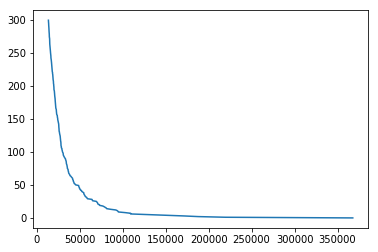

In [42]:
#Закон Ципфа
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [43]:
texts5 = []
for i in range(len(responses)):
    if responses[i]['rating_grade'] == 5:
        texts5.append(responses[i]['text'])

In [44]:
texts1 = []
for i in range(len(responses)):
    if responses[i]['rating_grade'] == 1:
        texts1.append(responses[i]['text'])

In [45]:
texts5 = pd.DataFrame(texts5)
texts1 = pd.DataFrame(texts1)

In [46]:
# по полному корпусу слов не отрабатывает

In [47]:
texts1.describe()

,0
count,47387
unique,47385
top,05.03.2015 года в 13:47:24 у м. Нагатинская в ...
freq,2


In [48]:
texts1 = texts1.loc[:, :5000]

In [49]:
texts1['lemma']= texts1[0].apply(remove_stopwords)
texts1['lemma'] = texts1['lemma'].apply(lemmatize)

In [50]:
texts5 = texts5.loc[:, :5000]

In [51]:
texts5['lemma']= texts5[0].apply(remove_stopwords)
texts5['lemma'] = texts5['lemma'].apply(lemmatize)

In [52]:
df1 = texts1['lemma']

In [53]:
df5 = texts5['lemma']

In [54]:
from gensim.models import  *
from gensim import similarities
from gensim.corpora import *

In [55]:
texts1 = [df1.iloc[i].split() for i in range(len(df1))]
dictionary = Dictionary(texts1)
corpus1 = [dictionary.doc2bow(text) for text in texts1]

In [57]:
#tfidf = TfidfModel(corpus1)
#corpus1_tfidf = tfidf[corpus1]

#index = similarities.MatrixSimilarity(corpus1_tfidf)
#sims = index[corpus1_tfidf]

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [58]:
texts.head()

,0,lemma
0,Добрый день! Я не являюсь клиентом банка и пор...,добрый день! я являться клиент банк поручитель...
1,Доброго дня! Являюсь держателем зарплатной кар...,добрый день! являться держатель зарплатной кар...
2,Здравствуйте! Дублирую свое заявление от 03.0...,здравствовать! дублировать заявление 03.06.201...
3,Добрый день!! Я открыл расчетный счет в СберБа...,добрый день!! я открывать расчетный счет сберб...
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...","04.03.2015 г. взять кредит ваш банк, заявлять ..."


In [59]:
df = texts['lemma']

In [60]:
from gensim.corpora import *
texts = [df.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [61]:
%%time
from gensim.models import  *
from gensim import similarities

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 30.8 µs


In [62]:
%%time
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=15,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

CPU times: user 1h 12s, sys: 1min 41s, total: 1h 1min 53s
Wall time: 20min 6s


In [63]:
lda.show_topics(15)

[(0,
  '0.051*"вы" + 0.049*"ваш" + 0.049*"номер" + 0.021*"телефон" + 0.021*"письмо" + 0.016*"данные" + 0.013*"адрес" + 0.011*"указывать" + 0.010*"мобильный" + 0.009*"почта"'),
 (1,
  '0.063*"сбербанк" + 0.046*"отделение" + 0.038*"г." + 0.034*"филиал" + 0.025*"ул." + 0.016*"сбербанк," + 0.013*"адрес" + 0.011*"сбербанк." + 0.011*"д." + 0.009*"москва"'),
 (2,
  '0.037*"заявление" + 0.029*"мой" + 0.022*"средство" + 0.021*"денежный" + 0.018*"банк" + 0.016*"претензия" + 0.013*"данный" + 0.012*"г." + 0.012*"написать" + 0.011*"счет"'),
 (3,
  '0.099*"банкомат" + 0.056*"деньги" + 0.023*"банкомат," + 0.018*"снимать" + 0.016*"карта" + 0.013*"выдавать" + 0.013*"банкомат." + 0.012*"вносить" + 0.011*"сумма" + 0.011*"наличный"'),
 (4,
  '0.012*"я" + 0.008*"а" + 0.008*"отделение" + 0.008*"и" + 0.007*"в" + 0.006*"работать" + 0.006*"очередь" + 0.006*"минута" + 0.006*"такой" + 0.005*"человек"'),
 (5,
  '0.088*"вклад" + 0.046*"открывать" + 0.023*"процент" + 0.022*"вклад," + 0.019*"деньги" + 0.019*"вклад."

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [64]:
texts5 = []
for i in range(len(responses)):
    if responses[i]['rating_grade'] == 5:
        texts5.append(responses[i]['text'])

In [65]:
texts1 = []
for i in range(len(responses)):
    if responses[i]['rating_grade'] == 1:
        texts1.append(responses[i]['text'])

In [66]:
texts5 = pd.DataFrame(texts5)
texts1 = pd.DataFrame(texts1)

In [67]:
texts1.describe()

,0
count,47387
unique,47385
top,05.03.2015 года в 13:47:24 у м. Нагатинская в ...
freq,2


In [68]:
texts1 = texts1.loc[:, :1000]

In [69]:
texts1['lemma']= texts1[0].apply(remove_stopwords)
texts1['lemma'] = texts1['lemma'].apply(lemmatize)

In [70]:
texts5 = texts5.loc[:, :1000]

In [71]:
texts5['lemma']= texts5[0].apply(remove_stopwords)
texts5['lemma'] = texts5['lemma'].apply(lemmatize)

In [72]:
df1 = pd.DataFrame(texts1['lemma'])

In [73]:
df1['y'] = 1

In [74]:
df5 = pd.DataFrame(texts5['lemma'])

In [75]:
df5['y'] = 5

In [76]:
df = pd.concat([df1, df5])

In [77]:
df.to_csv('df15.csv')

In [78]:
df = pd.read_csv('df15.csv')

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split 


X = df['lemma']
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


In [80]:
clf.fit(X_train, y_train)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range={4, 6}, preprocessor=None, stop_words=None,
        strip...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [81]:
y_pred = clf.predict(X_test)

In [82]:
from sklearn.metrics import *

Precision:   0.52
Recall:   0.51
F1-measure:   0.50
Accuracy:   0.71
              precision    recall  f1-score   support

           1       0.76      0.91      0.83      9383
           5       0.28      0.12      0.16      3037

   micro avg       0.71      0.71      0.71     12420
   macro avg       0.52      0.51      0.50     12420
weighted avg       0.64      0.71      0.66     12420



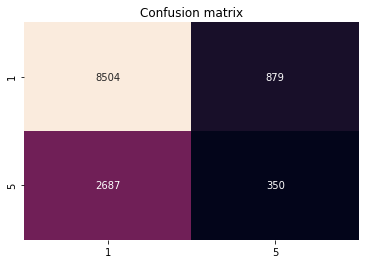

In [83]:
print("Precision: {0:6.2f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, y_pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
labels = clf.classes_



labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [84]:
from sklearn.decomposition import LatentDirichletAllocation

In [85]:
clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})), 
    ('tfidf', TfidfTransformer()),  
    ('clf', RandomForestClassifier(n_jobs = 3))
])

In [86]:
clf.fit(X_train, y_train)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range={4, 6}, preprocessor=None, stop_words=None,
        strip...n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [87]:
y_pred = clf.predict(X_test)

Precision:   0.90
Recall:   0.76
F1-measure:   0.80
Accuracy:   0.87
              precision    recall  f1-score   support

           1       0.86      0.99      0.92      9383
           5       0.94      0.52      0.67      3037

   micro avg       0.87      0.87      0.87     12420
   macro avg       0.90      0.76      0.80     12420
weighted avg       0.88      0.87      0.86     12420



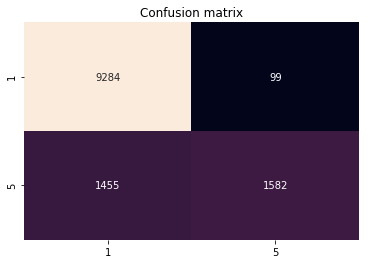

In [88]:
print("Precision: {0:6.2f}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, y_pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
labels = clf.classes_



labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [89]:
# Лучший результат дает классификатор с просто с tf-idf разложением, без LSA, LDA